In [1]:
%matplotlib inline
# 外部依赖项
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import metrics

# 定义一个偏差常量
EPS = 1E-8

In [2]:
import struct
# 读取MNIST与Fasion_Mnist的函数
## 读取图片部分
def mnist_load_images(file_name):
    # 在读取或写入一个文件之前，你必须使用 Python 内置open()函数来打开它。
    # file object = open(file_name [, access_mode][, buffering])
    # file_name是包含您要访问的文件名的字符串值。                         ##
    # access_mode指定该文件已被打开，即读，写，追加等方式。               ##
    # 0表示不使用缓冲，1表示在访问一个文件时进行缓冲。                    ##
    # 这里rb表示只能以二进制读取的方式打开一个文件
    binfile = open(file_name, 'rb')
    ##   从一个打开的文件读取数据
    buffers = binfile.read()
    ##   读取image文件前4个整型数字
    magic, num, rows, cols = struct.unpack_from('>IIII', buffers, 0)
    ##   整个images数据大小为60000*28*28
    bits = num * rows * cols
    ##   读取images数据
    images = struct.unpack_from('>' + str(bits) + 'B', buffers, struct.calcsize('>IIII'))
    ##   关闭文件
    binfile.close()
    ##   转换为[60000,784]型数组
    images = np.reshape(images, [num, rows * cols])
    return images

## 读取标记部分
def mnist_load_labels(file_name):
    ## 打开文件
    binfile = open(file_name, 'rb')
    ##   从一个打开的文件读取数据
    buffers = binfile.read()
    ##   读取label文件前2个整形数字，label的长度为num
    magic, num = struct.unpack_from('>II', buffers, 0)
    ##   读取labels数据
    labels = struct.unpack_from('>' + str(num) + "B", buffers, struct.calcsize('>II'))
    ##   关闭文件
    binfile.close()
    ##   转换为一维数组
    labels = np.reshape(labels, [num])
    return labels

def load_minst():
    mnist_train_image, mnist_train_label = mnist_load_images("./dataset/mnist_dataset/train-images.idx3-ubyte"), \
                       mnist_load_labels("./dataset/mnist_dataset/train-labels.idx1-ubyte")
    mnist_test_image, mnist_test_label = mnist_load_images("./dataset/mnist_dataset/t10k-images.idx3-ubyte"), \
                     mnist_load_labels("./dataset/mnist_dataset/t10k-labels.idx1-ubyte")

    return mnist_train_image, mnist_train_label, mnist_test_image, mnist_test_label

mnist_train_image, mnist_train_label, mnist_test_image, mnist_test_label = load_minst()

In [3]:
def get_58(X, Y):
    Y=Y.reshape((-1, 1))
    dataset = np.concatenate([X, Y], axis=1)
    dataset_5 = dataset[dataset[:, -1] == 5]
    dataset_8 = dataset[dataset[:, -1] == 8]
    dataset_5[:, -1] = -1.0
    dataset_8[:, -1] = 1.0

    data = np.concatenate([dataset_5, dataset_8], axis=0)#两个数组的拼接
    np.random.shuffle(data)
    return data[:, :-1], data[:, -1]

# mnist
mnist_train_58image, mnist_train_58label = get_58(mnist_train_image, mnist_train_label)
mnist_test_58image, mnist_test_58label = get_58(mnist_test_image, mnist_test_label)

D:\Software\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

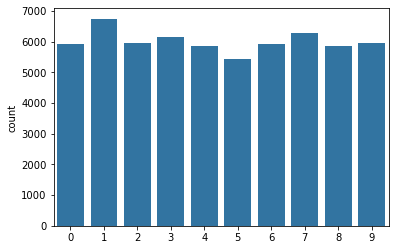

In [4]:
# mnist
import seaborn as sns
sns.countplot(mnist_train_label, color = sns.color_palette()[0])

In [5]:
from abc import abstractmethod
class Model:
    loss_saver = []

    @abstractmethod
    def fit(self, X, y):
        pass

    @abstractmethod
    def predict(self, X):
        pass

In [6]:
from tqdm import tqdm, trange

class Perceptron(Model):
    # 模型定义
    def __init__(self, alpha=0.03, n_iter=20):
        self.alpha = alpha #学习率
        self.n_iter = n_iter #迭代次数
        self.loss_saver = [] #损失收集

    # 模型训练
    def fit(self, X, Y):
        m, n = np.shape(X)
        self.bias = 0
        self.W = np.ones(n)

        for i in tqdm(range(self.n_iter)):
            for x, y in zip(X, Y):
                y_hat = np.dot(x, self.W) + self.bias

                if y * y_hat < 0.:
                    self.W += x * self.alpha * y
                    self.bias += self.alpha * y

            self.loss_saver.append(self.loss(X, Y))

            if self.loss(X, Y) < EPS:
                return

    def predict(self, X):
        return np.dot(X, self.W) + self.bias

    def loss(self, X, Y):
        return metrics.accuracy_score(Y, np.sign(self.predict(X)))

In [7]:
from scipy import linalg
class MSE(Model):
    def __init__(self, c=0.03, n_iter=20):
        self.c = c
        self.n_iter = n_iter
        self.loss_saver = []

    def fit(self, X, Y):
        m, n = X.shape
        b = np.ones((m, 1))
        X = np.concatenate([X, b], axis=1)
        Y = Y.reshape((-1, 1))
        X = X * Y

        self.b = np.ones(m, dtype=np.float)
        X_shape = linalg.pinv(X)

        for i in trange(self.n_iter):
            self.W = np.dot(X_shape, self.b)
            self.err = np.dot(X, self.W) - self.b
            self.b = self.b + self.c * (self.err + np.abs(self.err))
            self.loss_saver.append(np.linalg.norm(self.err, ord=2))
            if self.loss_saver[-1] < EPS:
                return

    def predict(self, X):
        b = np.ones((X.shape[0], 1))
        X = np.concatenate([X, b], axis=1)
        return np.dot(X, self.W)

In [8]:
from scipy import linalg
class Fisher(Model):
    def __init__(self, iter_n = 10):
        self.c = 0.
        self.iter_n = iter_n
        self.loss_saver = []

    @staticmethod
    def _cal_cov_avg(X):
        u = np.mean(X, axis=0)
        cov = np.cov(X, rowvar=False)

        return cov, u

    def fit(self, X, Y):
        Y = Y.reshape((-1, 1))
        X = X / 255
        X_full = np.concatenate([X, Y], axis=1)
        X_0 = X_full[X_full[:, -1] == -1]
        X_1 = X_full[X_full[:, -1] == 1]
        X_0, X_1 = X_0[:, :-1], X_1[:, :-1]
        cov_0, u_0 = self._cal_cov_avg(X_0)
        cov_1, u_1 = self._cal_cov_avg(X_1)

        s_w = cov_0 + cov_1
        s_w_inv = linalg.pinv(s_w)
        self.W = np.dot(s_w_inv, u_0 - u_1)
        self.u_0 = np.dot(u_0, self.W)
        self.u_1 = np.dot(u_1, self.W)
        acc = 0.
        c = 0.

        for i in trange(self.iter_n):
            self.c = i / self.iter_n
            l_acc = self.loss(X * 255, Y)
            self.loss_saver.append(l_acc)
            if l_acc > acc:
                c = self.c
                acc = l_acc

        self.c = c

    def loss(self, X, Y):
        return metrics.accuracy_score(Y, np.sign(self.predict(X)))

    def predict(self, X):
        X = X / 255
        return -(np.dot(X, self.W) - (self.u_0 + (self.u_1 - self.u_0) * self.c))

In [9]:
class OVR(Model):
    def __init__(self, model, n_class):
        self.model = model
        self.n_class = n_class

        self.models = []

        for i in range(n_class):
            self.models.append(model())

    def fit(self, X, Y):
        Y = Y.reshape((-1, 1))
        X_full = np.concatenate([X, Y], axis=1)

        for i in range(self.n_class):
            X_o = X_full[X_full[:, -1] == i].copy()
            X_r = X_full[X_full[:, -1] != i].copy()

            X_o, X_r = X_o[:, :-1], X_r[:, :-1]
            Y_o, Y_r = np.ones((X_o.shape[0], 1)), -np.ones((X_r.shape[0], 1))
            tmp_data_o = np.concatenate([X_o, Y_o], axis=1)
            tmp_data_r = np.concatenate([X_r, Y_r], axis=1)
            tmp_data = np.concatenate([tmp_data_r, tmp_data_o], axis=0)
            np.random.shuffle(tmp_data)
            tmp_X, tmp_Y = tmp_data[:, :-1], tmp_data[:, -1]
            self.models[i].fit(tmp_X, tmp_Y)

    def predict(self, X):
        n = X.shape[0]
        res, maxx = np.zeros(n), np.zeros(n)

        for i in range(self.n_class):
            tmp_res = self.models[i].predict(X)

            for j in range(n):
                if tmp_res[j] > maxx[j]:
                    res[j], maxx[j] = i, tmp_res[j]

        return res

In [10]:
from tqdm import trange

class SVM:
    def __init__(self, n_iter=100, kernel='linear'):
        self.max_iter = n_iter
        self._kernel = kernel

    def init_args(self, features, labels):
        self.m, self.n = features.shape
        self.X = features
        self.Y = labels
        self.b = 0.0

        self.alpha = np.ones(self.m)
        self.E = [self._E(i) for i in range(self.m)]
        self.C = 1.0

    def _KKT(self, i):
        y_g = self._g(i) * self.Y[i]
        if self.alpha[i] == 0:
            return y_g >= 1
        elif 0 < self.alpha[i] < self.C:
            return y_g == 1
        else:
            return y_g <= 1

    def _g(self, i):
        r = self.b
        for j in trange(self.m):
            r += self.alpha[j] * self.Y[j] * self.kernel(self.X[i], self.X[j])
        return r

    def kernel(self, x1, x2):
        if self._kernel == 'linear':
            return sum([x1[k] * x2[k] for k in range(self.n)])
        elif self._kernel == 'poly':
            return (sum([x1[k] * x2[k] for k in range(self.n)]) + 1)**2

        return 0

    def _E(self, i):
        return self._g(i) - self.Y[i]

    def _init_alpha(self):
        index_list = [i for i in range(self.m) if 0 < self.alpha[i] < self.C]
        non_satisfy_list = [i for i in range(self.m) if i not in index_list]
        index_list.extend(non_satisfy_list)

        for i in index_list:
            if self._KKT(i):
                continue

            E1 = self.E[i]
            if E1 >= 0:
                j = min(range(self.m), key=lambda x: self.E[x])
            else:
                j = max(range(self.m), key=lambda x: self.E[x])
            return i, j

    def _compare(self, _alpha, L, H):
        if _alpha > H:
            return H
        elif _alpha < L:
            return L
        else:
            return _alpha

    def fit(self, features, labels):
        self.init_args(features, labels)

        for t in trange(self.max_iter):
            i1, i2 = self._init_alpha()

            if self.Y[i1] == self.Y[i2]:
                L = max(0, self.alpha[i1] + self.alpha[i2] - self.C)
                H = min(self.C, self.alpha[i1] + self.alpha[i2])
            else:
                L = max(0, self.alpha[i2] - self.alpha[i1])
                H = min(self.C, self.C + self.alpha[i2] - self.alpha[i1])

            E1 = self.E[i1]
            E2 = self.E[i2]
            eta = self.kernel(self.X[i1], self.X[i1]) + self.kernel(
                self.X[i2],
                self.X[i2]) - 2 * self.kernel(self.X[i1], self.X[i2])
            if eta <= 0:
                continue

            alpha2_new_unc = self.alpha[i2] + self.Y[i2] * (
                E1 - E2) / eta
            alpha2_new = self._compare(alpha2_new_unc, L, H)

            alpha1_new = self.alpha[i1] + self.Y[i1] * self.Y[i2] * (
                self.alpha[i2] - alpha2_new)

            b1_new = -E1 - self.Y[i1] * self.kernel(self.X[i1], self.X[i1]) * (
                alpha1_new - self.alpha[i1]) - self.Y[i2] * self.kernel(
                    self.X[i2],
                    self.X[i1]) * (alpha2_new - self.alpha[i2]) + self.b
            b2_new = -E2 - self.Y[i1] * self.kernel(self.X[i1], self.X[i2]) * (
                alpha1_new - self.alpha[i1]) - self.Y[i2] * self.kernel(
                    self.X[i2],
                    self.X[i2]) * (alpha2_new - self.alpha[i2]) + self.b

            if 0 < alpha1_new < self.C:
                b_new = b1_new
            elif 0 < alpha2_new < self.C:
                b_new = b2_new
            else:
                b_new = (b1_new + b2_new) / 2

            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new
            self.b = b_new

            self.E[i1] = self._E(i1)
            self.E[i2] = self._E(i2)

    def predict(self, data):
        r = self.b
        for i in range(self.m):
            r += self.alpha[i] * self.Y[i] * self.kernel(data, self.X[i])

        return 1 if r > 0 else -1

    def _weight(self):
        yx = self.Y.reshape(-1, 1) * self.X
        self.w = np.dot(yx.T, self.alpha)
        return self.w

In [11]:
def evaluate2one(model:Model, train_image, train_label, test_image, test_label):
    print("Start evaluating.")
    y_ = np.sign(model.predict(train_image))

    print("Train acc: {}".format(metrics.accuracy_score(train_label, y_)))
    t_y = model.predict(test_image)
    print("Test acc: {}".format(metrics.accuracy_score(test_label, np.sign(t_y))))

    print("-" * 60)

    plt.figure()
    x = np.arange(len(model.loss_saver))
    y = np.array(model.loss_saver)
    plt.plot(x, y)
    plt.show()

    fpr, tpr, _ = metrics.roc_curve(test_label, t_y)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    plt.semilogx(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def evaluate2two(model:Model, train_image, train_label, test_image, test_label):
    print("Start evaluating.")
    y_ = np.sign(model.predict(train_image))

    print("Train acc: {}".format(metrics.accuracy_score(train_label, y_)))
    t_y = model.predict(test_image)
    print("Test acc: {}".format(metrics.accuracy_score(test_label, np.sign(t_y))))

    print("-" * 60)

    fpr, tpr, _ = metrics.roc_curve(test_label, t_y)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    plt.semilogx(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


def train2one(model:Model, train_image, train_label, test_image, test_label):
    # training
    print("-" * 60)
    print("Train starting.")
    model.fit(train_image,train_label)
    print("Train finished.")

    # evaluating
    evaluate2one(model, train_image, train_label, test_image, test_label)

def train2two(model:Model, train_image, train_label, test_image, test_label):
    # training
    print("-" * 60)
    print("Train starting.")
    model.fit(train_image,train_label)
    print("Train finished.")

    # evaluating
    evaluate2two(model, train_image, train_label, test_image, test_label)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def trainN(model, train_image, train_label, test_image, test_label):
    #training
    print("-" * 60)
    print("Train starting.")
    model.fit(train_image, train_label)
    print("Train finished.")
    print("Evaluate starting.")

    ty = model.predict(train_image)
    dy = model.predict(test_image)

    print("Train acc: {}".format(metrics.accuracy_score(train_label,ty)))
    print("Test acc: {}".format(metrics.accuracy_score(test_label,dy)))

    print("-" * 60)
    print(classification_report(test_label,dy))
    con_mat = confusion_matrix(test_label, dy)
    con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    sns.heatmap(con_mat_norm, annot=True, fmt='.2f', cmap='rainbow', lw=.5)
    ax1.set_ylim(0, 10)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.figure.set_size_inches(30,10)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(con_mat, annot=True, fmt='.0f', cmap='rainbow', lw=.5)
    ax2.set_ylim(0, 10)
    ax2.set_xlabel('Predicted labels')
    ax2.set_ylabel('True labels')
    ax2.figure.set_size_inches(30,10)

    fig.tight_layout(pad=0.4, w_pad=3.0, h_pad=3.0)

------------------------------------------------------------
Train starting.
Train finished.
Evaluate starting.
Train acc: 0.9899166666666667
Test acc: 0.9792
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



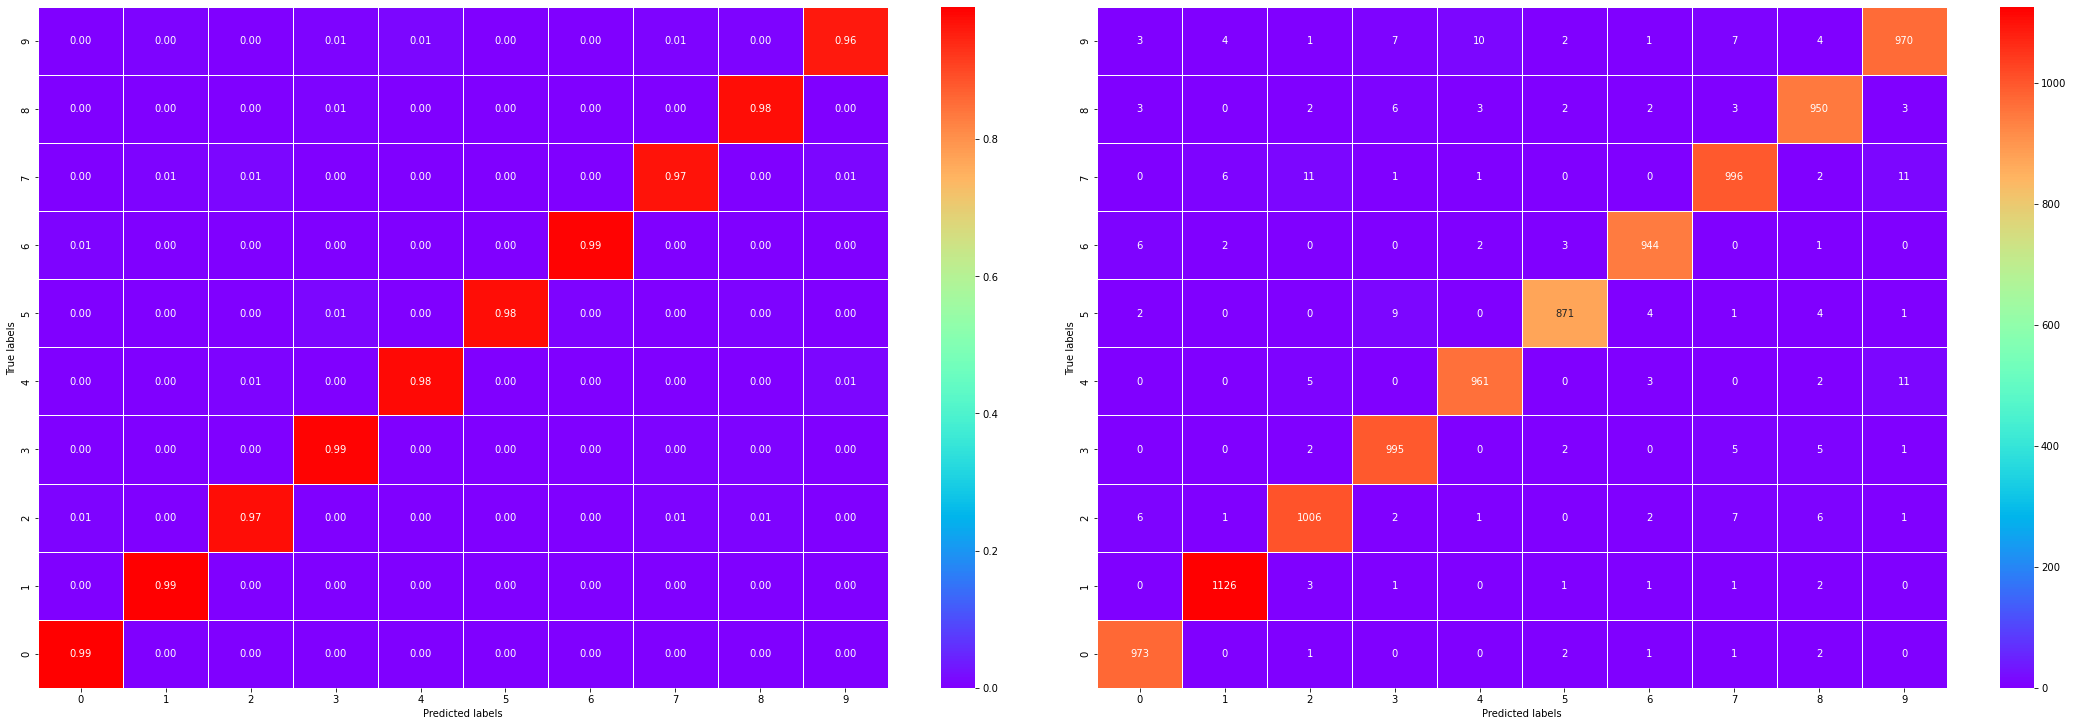

In [13]:

# svm 10 ovr
# mnist
trainN(SVM.SVC(decision_function_shape='ovr'), mnist_train_image, mnist_train_label, mnist_test_image, mnist_test_label)